## Import and Functions

In [1]:
import os
import sys
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten

2022-06-20 11:25:35.509747: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-20 11:25:35.512210: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-20 11:25:35.512218: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def norm(lst, max_val):
    return np.array([val/max_val for val in lst])

def denorm(lst, max_val):
    return np.array([val*max_val for val in lst])

## Random Seeds and Data Import

In [3]:
# Set a seed value: 
keras.utils.set_random_seed(5)

In [4]:
with open("data/pickle/data", 'rb') as file:
    var = pickle.load(file=file)
    max_y            = var["max_y"][:][0]
    train_x_data     = var["train_x_data"][:]
    train_y_data     = var["train_y_data"][:]
    test_time_sorted = var["test_time_sorted"][:]
    test_x_sorted    = var["test_x_sorted"][:]
    test_y_sorted    = var["test_y_sorted"][:]

## Building Model

In [5]:
model = Sequential()
model.add(Conv1D(8, kernel_size=3, activation='relu', input_shape=(96, 1)))
model.add(MaxPool1D(2))
model.add(Conv1D(8, kernel_size=3, activation='relu'))
model.add(MaxPool1D(4))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
#model.summary()

2022-06-20 11:25:36.516125: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-20 11:25:36.516147: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-20 11:25:36.516165: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ayu): /proc/driver/nvidia/version does not exist
2022-06-20 11:25:36.516673: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Training algorithm

In [6]:
model.compile(loss = lambda y_true, y_pred: keras.losses.huber(y_true, y_pred, .75), 
   optimizer = keras.optimizers.Adam(), metrics = ['MeanAbsolutePercentageError'])

In [7]:
step_num = 12800#int(len(train_y_data)//32)
history = model.fit(
    x=train_x_data[:], y=train_y_data[:], epochs=10, batch_size=32, steps_per_epoch=step_num,
    validation_split=.1, workers=8, use_multiprocessing=True, verbose=2)

Epoch 1/10
12800/12800 - 17s - loss: 0.0014 - mean_absolute_percentage_error: 5.4779 - val_loss: 2.9080e-04 - val_mean_absolute_percentage_error: 3.0457 - 17s/epoch - 1ms/step
Epoch 2/10
12800/12800 - 18s - loss: 2.2004e-04 - mean_absolute_percentage_error: 2.6859 - val_loss: 1.6314e-04 - val_mean_absolute_percentage_error: 2.3562 - 18s/epoch - 1ms/step
Epoch 3/10
12800/12800 - 17s - loss: 1.5166e-04 - mean_absolute_percentage_error: 2.2750 - val_loss: 1.2825e-04 - val_mean_absolute_percentage_error: 1.9948 - 17s/epoch - 1ms/step
Epoch 4/10
12800/12800 - 17s - loss: 1.1599e-04 - mean_absolute_percentage_error: 2.0322 - val_loss: 1.0011e-04 - val_mean_absolute_percentage_error: 1.9293 - 17s/epoch - 1ms/step
Epoch 5/10
12800/12800 - 18s - loss: 1.0114e-04 - mean_absolute_percentage_error: 1.9056 - val_loss: 9.9002e-05 - val_mean_absolute_percentage_error: 1.8486 - 18s/epoch - 1ms/step
Epoch 6/10
12800/12800 - 17s - loss: 8.7052e-05 - mean_absolute_percentage_error: 1.7849 - val_loss: 7.2

## Testing Model

In [8]:
perf = model.evaluate(test_x_sorted, test_y_sorted)

1581/1581 [==============================] - 1s 931us/step - loss: 5.5443e-05 - mean_absolute_percentage_error: 1.4746


In [9]:
pred_y = model.predict(test_x_sorted)

1581/1581 [==============================] - 1s 872us/step


In [10]:
denorm_test = denorm(test_y_sorted, max_y)
denorm_pred = denorm(pred_y, max_y)[:,0]
lst = list(map(lambda i: abs(denorm_pred[i]-denorm_test[i])/denorm_test[i],
               range(len(pred_y))))

pd.DataFrame(lst).describe()

,0
count,50573.000000
mean,0.014746
std,0.021715
min,0.000001
25%,0.004195
50%,0.009170
75%,0.017675
max,0.994512


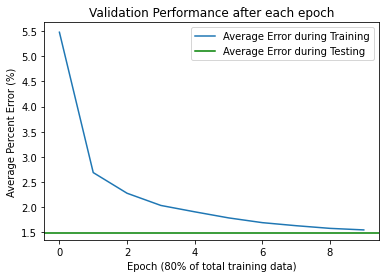

In [11]:
plt.figure(facecolor='w')
plt.title("Validation Performance after each epoch")
plt.plot(history.history["mean_absolute_percentage_error"], label="Average Error during Training")
plt.axhline(perf[1], color='g', label="Average Error during Testing")
plt.xlabel("Epoch (80% of total training data)")
plt.ylabel("Average Percent Error (%)")
plt.legend()
#plt.savefig("plots/validation_performance_over_time.png")

1581/1581 [==============================] - 1s 833us/step


ValueError: x and y must have same first dimension, but have shapes (1, 50573) and (50573,)

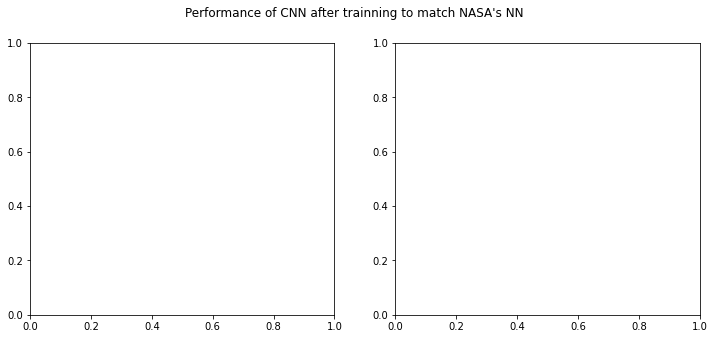

In [12]:
pred_y = model.predict(test_x_sorted)
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(6*2,5), facecolor='w')
fig.suptitle("Performance of CNN after trainning to match NASA's NN")

ax0.plot(test_time_sorted, denorm(test_y_sorted, max_y), label="Neural Network(estimated)",linewidth=2)
ax0.plot(test_time_sorted, denorm(pred_y, max_y), label="Convolutional Neural Network",linewidth=2)
ax0.set_title("Predicted vs Estimated Plasma Frequency over time")
ax0.set_xlabel("Time (s)")
ax0.set_ylabel("Plasma Frequency (kHz)")
ax0.legend()

res = np.subtract(denorm(pred_y, max_y)[:,0],denorm(test_y_sorted, max_y))
ax1.axhline(0, color='black', linewidth=1, label="Reference Line")
ax1.scatter(test_time_sorted, res, s=3, label="y_CNN - y_NN")
denorm_test = denorm(test_y_sorted, max_y)
for i in range(len(res)):
    if denorm_test[i] < 10:
        ax1.scatter(test_time_sorted[i], res[i], s=3, color='r')

ax1.set_title("Difference between CNN and NN")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Residuals")
ax1.legend(loc='lower right')

fig.savefig("plots/performance_on_test_dataset.png", dpi=500)

In [ ]:
plt.figure(facecolor='w')
plt.title("Histogram of percent error distribution")
plt.hist([v for v in lst], bins=1000)
plt.xlim((0,.2))
#plt.savefig("plots/file.png")